In [1]:
from music21 import midi
import numpy as np
from pypianoroll import Multitrack, Track
from matplotlib import pyplot as plt

from visual_midi import Plotter
from visual_midi import Preset
from pretty_midi import PrettyMIDI

import glob
import os
import subprocess
import math
from IPython.display import Image, display

In [55]:
def parenthetic_contents(string):
    """Generate parenthesized contents in string as pairs (level, contents)."""
    stack = []
    for i, c in enumerate(string):
        if c == '(':
            stack.append(i)
        elif c == ')' and stack:
            start = stack.pop()
            if len(stack)==1:
                yield (len(stack), string[start + 1: i])
def get_feature(mid_file, long_short_threshold = 16):

    out = subprocess.run(["java", "-jar","omnisia.jar","-i",mid_file,"-draw"],stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    txt = out.stdout.decode('utf-8')
    log_folder = txt.split("\n")[5].split(":")[-1][1:]
    cos_file = glob.glob(log_folder+"/*.cos")[0]
    png_file = glob.glob(log_folder+"/*.png")
    print("found image", png_file)
    ratio = None
    file_lst_with_long_pattern = []
    with open(cos_file, "r") as f:
        lines = f.readlines()
        ratio = [float(line.split(" ")[-1]) for line in lines if line.startswith("compressionRatio ")][0]
        if math.isnan(ratio):
            ratio = 1
        pattern_occurence = [(list(parenthetic_contents(line))[0][1], list(parenthetic_contents(line))[1][1].count("v")) for line in lines if line.startswith("T")]
        #span: number of 16th notes 220:16th note, 880: 1/4note, 3520: 1note
        span_occurence = [(  (float(p_o[0].split("p")[-1].split(",")[0][1:])- float(p_o[0].split("p")[1].split(",")[0][1:]))/220
                              ,p_o[1]
                          ) for p_o in pattern_occurence if p_o[1]!=1]
        num_long_pattern= sum([x[1] for x in span_occurence if x[0]>=long_short_threshold])
        if num_long_pattern>0:
            print("long pattern exists",mid_file)
            playmid(mid_file)
            loadimg(png_file)
            current_file_has_long_pattern = True
        else:
            current_file_has_long_pattern = False
            #subprocess.run(["rm", "-rf",log_folder])
        num_short_pattern = sum([x[1] for x in span_occurence if x[0]<long_short_threshold])
        

    return ratio, num_long_pattern, num_short_pattern, current_file_has_long_pattern


In [56]:
def playmid(mid_file):
    f = midi.MidiFile()
    f.open(mid_file)
    f.read()
    f.close()
    s = midi.translate.midiFileToStream(f)
    '''preset = Preset(plot_width=850)
    plotter = Plotter(preset, plot_max_length_bar=4)
    pm = PrettyMIDI(mid_file)
    plotter.show_notebook(pm) '''
    it_pianoroll = Multitrack(mid_file)
    it_pianoroll.parse_pretty_midi(PrettyMIDI(mid_file),algorithm='custom', first_beat_time=0.0)
    fig, axs = it_pianoroll.plot()
    plt.show()

    s.show("midi")
def loadimg(path):
    
    display(Image(filename=path) )
    

In [59]:
ls xml_test_decoded_omi/Pop/queen_dont-stop-me-now_verse_pre-chorus_chorus-mid-2020-10-30-06-50-33-614

queen_dont-stop-me-now_verse_pre-chorus_chorus-chrom.cos
queen_dont-stop-me-now_verse_pre-chorus_chorus-chrom.log
queen_dont-stop-me-now_verse_pre-chorus_chorus.log
queen_dont-stop-me-now_verse_pre-chorus_chorus.pts
queen_dont-stop-me-now_verse_pre-chorus_chorus.switches


hey hey 
Parameter values
Basic algorithm: (-a): COSIATEC
Input file (-i): /PROJ/SampleRNN_event/xml_test_decoded_omi/Pop/queen_dont-stop-me-now_verse_pre-chorus_chorus.mid
Output directory (-o): /PROJ/SampleRNN_event/xml_test_decoded_omi/Pop/queen_dont-stop-me-now_verse_pre-chorus_chorus-mid-2020-10-30-06-50-33-614
Morphetic (diatonic) pitch (-d): false
MIREX (-m): false
Compactness trawler (-ct): false
Minimum compactness of trawled patterns (-cta): 0.67
Minimum size of trawled patterns (-ctb): 3
For r superdiagonals (-rsd): false
r (-r): 1
Remove redundant translators (-rrt): false
Minimum TEC compactness (-minc): 0.0
Minimum pattern size (-min): 0
Maximum pattern size (-max): Unlimited
Merge TECS (-merge): false
Minimum match size if TECs are merged (-minm): 5
Number of iterations if TECs are merged (-spins): 10
Remove channel 10 (drum channel) in MIDI (-no10): false
Help requested (-h): false
Draw analysis (-draw): true
Minimum compression ratio in Forth's algorithm (-crlow): 0.2


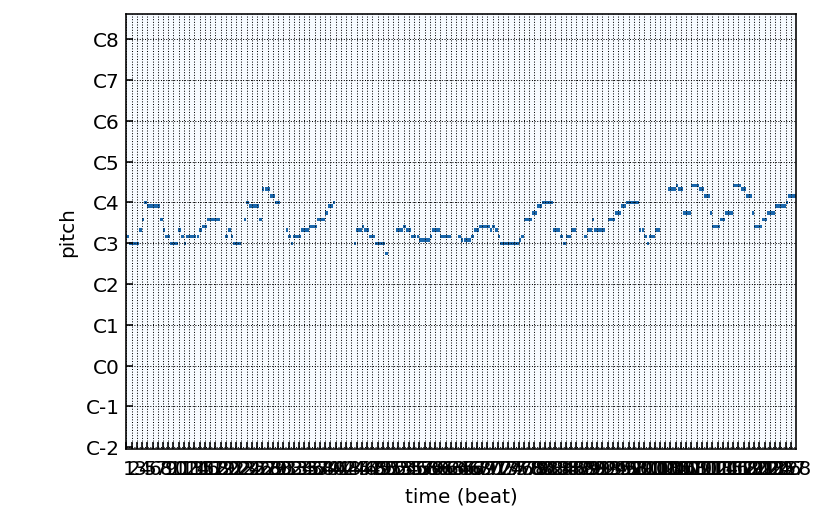

TypeError: expected str, bytes or os.PathLike object, not list

In [57]:
#folders_2b_evalutated = ["./test/generated_result/10_26_2020_11_14_22_Electronic_note/120000/8/0.7_0.8", "test/generated_result/10_24_2020_13_39_33_Electronic_nosamplernn/120000/16/0.6_0.6"]
folders_2b_evaluated = ["xml_test_decoded_omi/Pop"]
lst_of_long_pattern = []
for folder in folders_2b_evaluated:
    mid_files_lst = glob.glob(folder+"/*.mid")
    mid_files_lst2 = glob.glob(folder+"/*.mid")
    #mid_files_lst2 = [f for f in mid_files_lst if f.split("_")[-1]=="eva.mid"]

    #evaluate a folder of files
    feature_4_each_file = [get_feature(mid_file, long_short_threshold= 64) for mid_file in mid_files_lst2]
    ratio_4_folder = sum([x[0]for x in feature_4_each_file])/len(mid_files_lst2)
    long_patterns_4_folder = sum([x[1]for x in feature_4_each_file])
    short_patterns_4_folder = sum([x[2]for x in feature_4_each_file])
    mask_lst = [x[3] for x in feature_4_each_file]
    files_with_long_pattern = [x for x, y in zip(mid_files_lst, mask_lst) if y is True]
    print(folder,"ratio:",ratio_4_folder, "long pattern:",long_patterns_4_folder, "short pattern:",short_patterns_4_folder, "files_with_long_pattern", files_with_long_pattern)

In [ ]:
#path = "test/generated_result/10_26_2020_11_14_22_Electronic_note/120000/8/0.5/10_26_2020_11_14_22_Electronic_note_120000_8_0.5_a_alesso_clash_instrumental.mid"
paths = glob.glob("test/generated_result/10_26_2020_11_14_22_Electronic_note/120000/8/0.7_0.8/10_26_2020_11_14_22_Electronic_note_120000_8_0.7_0.8_z_zedd-ft-ryan-tedder_lost-at-sea_verse_chorus.mid")
unsucessful_lst = []
for path in paths:
    print("hey",path)
    try:
        playmid(path)
    except:
        unsucessful_lst.append(path)
print(unsucessful_lst)

In [ ]:
paths = glob.glob("test/generated_result/10_27_2020_03_04_51_Electronic_bar_note/120000/8/0.7_0.8/*.mid")
unsucessful_lst = []
for path in paths:
    print("path:",path)
    try:
        playmid(path)
    except:
        unsucessful_lst.append(path)
print(unsucessful_lst)

In [ ]:
paths = glob.glob("test/generated_result/10_27_2020_03_05_21_Electronic_bar_note/120000/8/0.5_0.5/*.mid")
unsucessful_lst = []
for path in paths:
    print("path:",path)
    try:
        playmid(path)
    except:
        unsucessful_lst.append(path)
print(unsucessful_lst)

In [ ]:
paths = glob.glob("test/generated_result/10_27_2020_03_05_21_Electronic_bar_note/120000/8/0.6_0.6/*.mid")
unsucessful_lst = []
for path in paths:
    print("path:",path)
    try:
        playmid(path)
    except:
        unsucessful_lst.append(path)
print(unsucessful_lst)

In [ ]:
paths = glob.glob("test/generated_result/10_27_2020_03_04_51_Electronic_bar_note/120000/8/0.6_0.6/*.mid")
unsucessful_lst = []
for path in paths:
    print("path:",path)
    try:
        playmid(path)
    except:
        unsucessful_lst.append(path)
print(unsucessful_lst)

In [ ]:
paths = glob.glob("test/generated_result/10_24_2020_08_42_59_Electronic_nosamplernn/120000/64/0.6_0.6/*.mid")
unsucessful_lst = []
for path in paths:
    print("path:",path)
    try:
        playmid(path)
    except:
        unsucessful_lst.append(path)
print(unsucessful_lst)

In [ ]:
paths = glob.glob("test/generated_result/10_24_2020_13_39_33_Electronic_nosamplernn/120000/16/0.6_0.6/*.mid")

unsucessful_lst = []

for path in paths:
    print("path:",path)
    if path.split("_")[-1]=="eva.mid":
        try:
            playmid(path)
        except:
            unsucessful_lst.append(path)
print(unsucessful_lst)
      
      